# MNIST dataset pratice

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

## Load dataset and explore

(28, 28, 1) 4


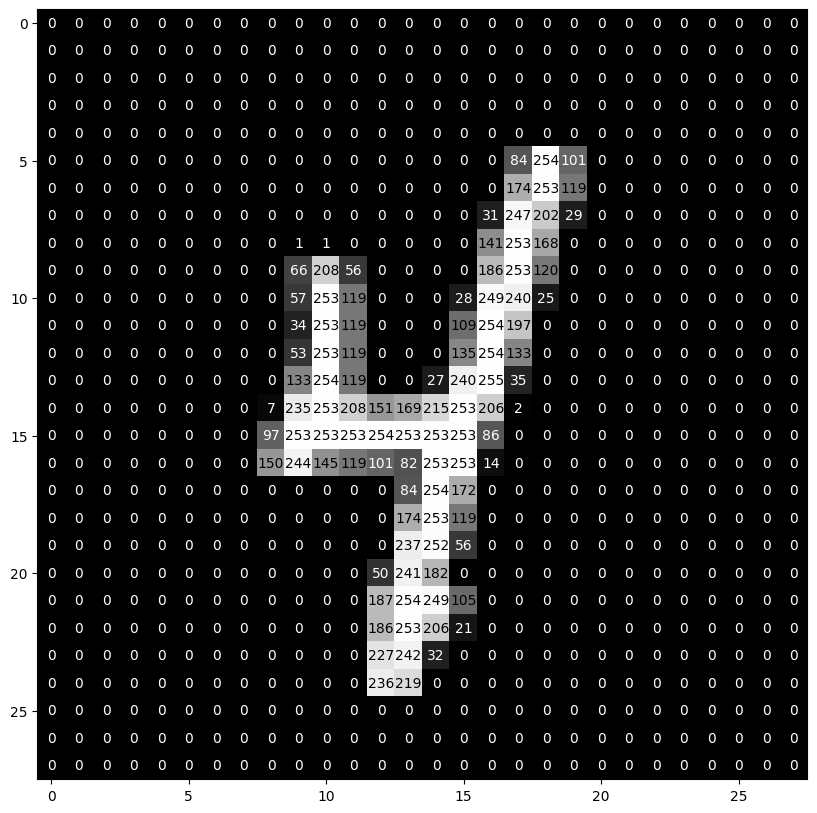

In [2]:
(train_ds, test_ds), info = tfds.load('mnist', split=['train', 'test'], as_supervised=True, with_info=True)

example = train_ds.take(1)
for data in example:
    img = tfds.as_numpy(data[0])
    label = data[1]
    print(img.shape, tfds.as_numpy(label))
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.imshow(data[0], cmap='gray', vmin=0, vmax=255)
    width, height, _ = img.shape
    tresh = img.max() / 2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(img[x][y][0]), xy=(y, x),
                            horizontalalignment='center',
                            verticalalignment='center',
                            color='white' if img[x][y][0] < tresh else 'k')



## Build the DNN

In [3]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(28, 28, 1)))
model.add(tf.keras.layers.Rescaling(1. / 255))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4), metrics=['accuracy'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,234 (860.29 KB)

 Trainable params: 220,234 (860.29 KB)

 Non-trainable params: 0 (0.00 B)

## Prepare data

In [4]:
BATCH_SIZE = 20
num_classes = 10

def preprocess(image, label):
    label = tf.one_hot(label, depth=num_classes)
    return image, label

def prepare_dataset(ds, shuffle=False):
    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)  # Loads 1000 samples in-memory to be shuffled
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)  # Fetch batches in the background. Automatically optimizes the number of parallel calls and prefetching

    return ds

train_ds = prepare_dataset(train_ds, shuffle=True)
test_ds = prepare_dataset(test_ds)


## Train the model

In [60]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="{epoch:02d}-{val_loss:.2f}.keras", save_best_only=True)
hist = model.fit(train_ds, epochs=100, validation_data=test_ds, callbacks=[checkpointer], verbose=True)

Epoch 1/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.8151 - loss: 0.6974 - val_accuracy: 0.9647 - val_loss: 0.1137
Epoch 2/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - accuracy: 0.9660 - loss: 0.1104 - val_accuracy: 0.9766 - val_loss: 0.0729
Epoch 3/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - accuracy: 0.9774 - loss: 0.0756 - val_accuracy: 0.9769 - val_loss: 0.0666
Epoch 4/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - accuracy: 0.9822 - loss: 0.0612 - val_accuracy: 0.9822 - val_loss: 0.0556
Epoch 5/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - accuracy: 0.9840 - loss: 0.0526 - val_accuracy: 0.9835 - val_loss: 0.0530
Epoch 6/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.9862 - loss: 0.0472 - val_accuracy: 0.9870 - val_loss: 0.0405
Epoch 7/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.9875 - loss: 0.0425 - val_accuracy: 0.9866 - val_loss: 0.0400
Epoch 8/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.9889 -

## Load and evaluate trained model

In [ ]:
# model.load_weights()
# score = model.evaluate()